# Etapa 1

In [10]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
import random
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
import os
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.feature import hog, orb
from sklearn.preprocessing import StandardScaler
import pandas as pd

dim = 100




In [11]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [12]:
train_images, train_labels = load_mnist('./fashion', kind='train')
test_images, test_labels = load_mnist('./fashion', kind='t10k')

print(f"Dimensiunea setului de date de antrenament: {train_images.shape}")
print(f"Dimensiunea setului de date de test: {test_images.shape}")


Dimensiunea setului de date de antrenament: (60000, 784)
Dimensiunea setului de date de test: (10000, 784)


## Extragere atribute

In [13]:

import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile


def preprocess_images(images, target_size=(32, 32)):
    resized_images = []
    for img in images:
        img = img.reshape(28, 28) 
        resized_img = cv2.resize(img, target_size) 
        resized_images.append(resized_img)
    return np.array(resized_images)

def extract_features_orb(images, max_keypoints=300, edge_threshold=6):
    orb = cv2.ORB_create(nfeatures=max_keypoints, edgeThreshold=edge_threshold,  patchSize=4)
    descriptors_list = []
    
    for img in images:
        gray_img = img.astype(np.uint8)  
        keypoints, descriptors = orb.detectAndCompute(gray_img, None)
        
        if descriptors is not None:
            descriptors_list.append(descriptors)
        else:
            descriptors_list.append(np.zeros((1, 32)))  
    
    return descriptors_list


def cluster_features(descriptors_list, n_clusters=50):
    non_empty_descriptors = [desc for desc in descriptors_list if desc.shape[0] > 0]
    
    if len(non_empty_descriptors) == 0:
        raise ValueError("No valid descriptors found in any image.")
    
    all_descriptors = np.vstack(non_empty_descriptors)
    
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans


def generate_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None and len(descriptors) > 0:
            labels = kmeans.predict(descriptors)  
            histogram, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters + 1)) 
        else:
            histogram = np.zeros(kmeans.n_clusters)  
        histograms.append(histogram)
    return np.array(histograms)


def reduce_dimensionality(features, n_components=20):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)  
    pca = PCA(n_components=n_components, random_state=42)
    reduced_features = pca.fit_transform(scaled_features) 
    
    print(f"Explained variance ratio of PCA components: {pca.explained_variance_ratio_}")
    
    return reduced_features, scaler, pca


def feature_selection(features, method='variance', percentile=10):
    if method == 'variance':
        selector = VarianceThreshold(threshold=0.01)
    elif method == 'percentile':
        selector = SelectPercentile(percentile=percentile)  
    else:
        raise ValueError("Method for feature selection must be 'variance' or 'percentile'.")
    
    selected_features = selector.fit_transform(features)
    return selected_features, selector



# Preprocess images (resize to 32x32)
train_resized = preprocess_images(train_images, target_size=(32, 32))
test_resized = preprocess_images(test_images, target_size=(32, 32))

# Extract ORB descriptors
train_descriptors = extract_features_orb(train_resized)
test_descriptors = extract_features_orb(test_resized)

# Check how many images have valid descriptors
print(f"Number of images with valid descriptors in training set: {sum([len(desc) > 0 for desc in train_descriptors])}")
print(f"Number of images with valid descriptors in test set: {sum([len(desc) > 0 for desc in test_descriptors])}")

# Apply KMeans clustering to the ORB descriptors
n_clusters = 100  # Number of clusters
kmeans = cluster_features(train_descriptors, n_clusters=n_clusters)

# Generate histograms based on KMeans clusters
train_histograms = generate_histograms(train_descriptors, kmeans)
test_histograms = generate_histograms(test_descriptors, kmeans)

# Standardize and reduce dimensionality
train_scaled, scaler, pca = reduce_dimensionality(train_histograms, n_components=20)
test_scaled = pca.transform(scaler.transform(test_histograms))

# Feature selection
train_selected, selector = feature_selection(train_scaled, method='variance', percentile=10)
test_selected = selector.transform(test_scaled)

# Print final dimensions of training and test sets
print(f"Final training set dimensions: {train_selected.shape}")
print(f"Final test set dimensions: {test_selected.shape}")




Number of images with valid descriptors in training set: 60000
Number of images with valid descriptors in test set: 10000
Explained variance ratio of PCA components: [0.06424672 0.03788565 0.02690913 0.02021468 0.0170203  0.01391495
 0.01260516 0.01186958 0.01149611 0.01104094 0.01030308 0.01002664
 0.00984748 0.00976564 0.0094892  0.00947376 0.0092516  0.00921993
 0.00914134 0.00903673]
Final training set dimensions: (60000, 20)
Final test set dimensions: (10000, 20)


## Visualizarea distributei claselor

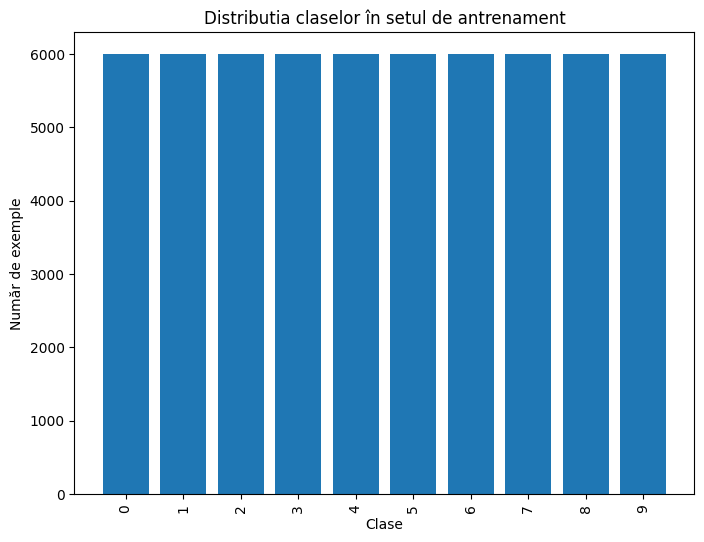

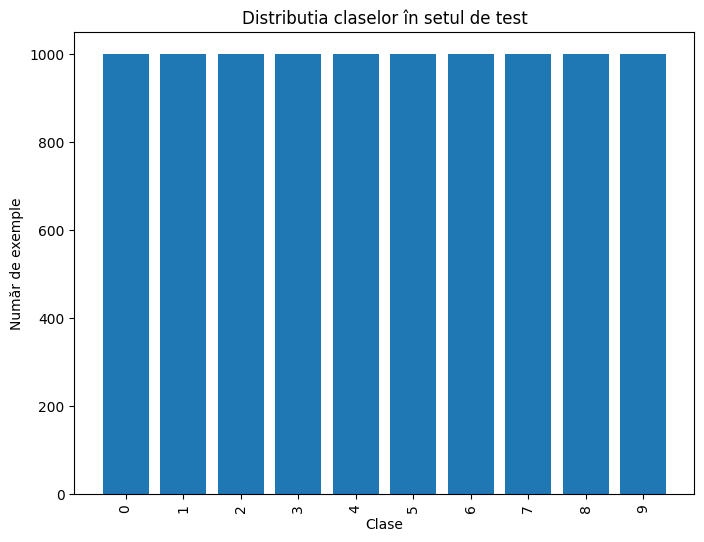

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(labels, title="Distributia claselor"):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 6))
    plt.bar(unique, counts, tick_label=unique)
    plt.xlabel('Clase')
    plt.ylabel('Număr de exemple')
    plt.title(title)
    plt.xticks(rotation=90)  
    plt.show()


plot_class_distribution(train_labels, title="Distributia claselor în setul de antrenament")
plot_class_distribution(test_labels, title="Distributia claselor în setul de test")


### Cantitatea de variabilitate explicata de PCA

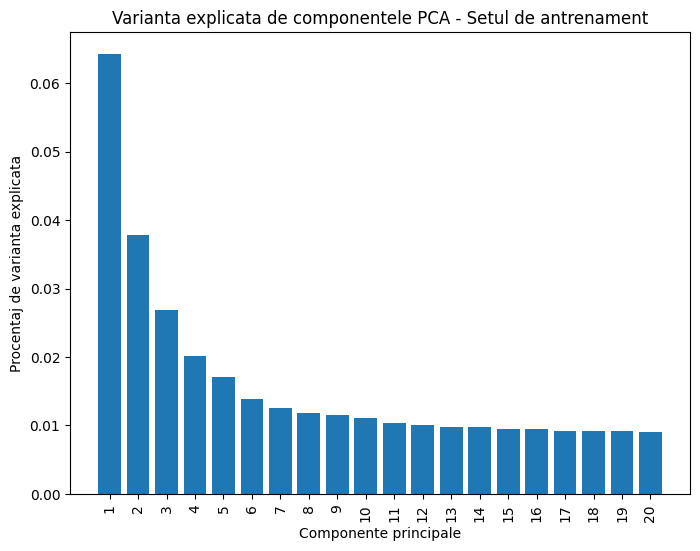

In [15]:
import matplotlib.pyplot as plt


def plot_pca_variance_explained(pca, title="Varianta explicata de componentele PCA"):
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, tick_label=range(1, len(explained_variance) + 1))
    plt.xlabel('Componente principale')
    plt.ylabel('Procentaj de varianta explicata')
    plt.title(title)
    plt.xticks(rotation=90)  
    plt.show()


plot_pca_variance_explained(pca, title="Varianta explicata de componentele PCA - Setul de antrenament")


###  Varianta cumulativa explicata de componentele principale (PCA).

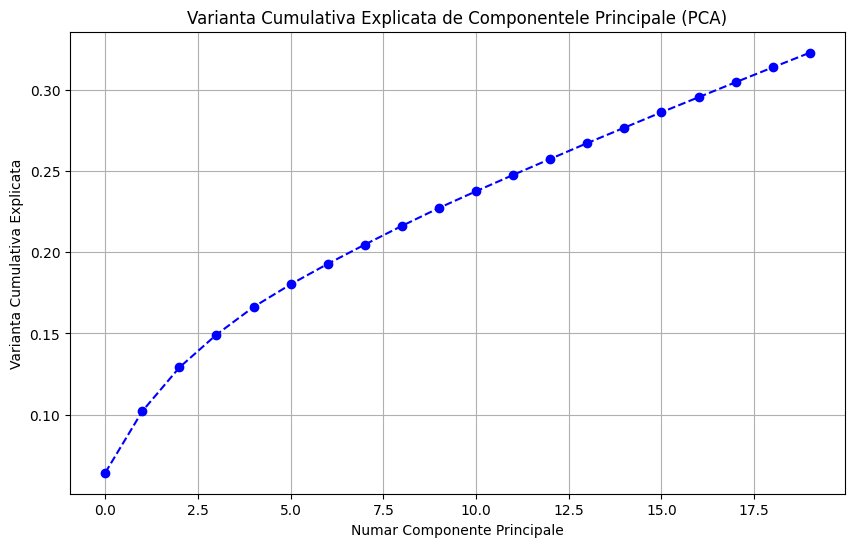

In [16]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Varianta Cumulativa Explicata de Componentele Principale (PCA)')
plt.xlabel('Numar Componente Principale')
plt.ylabel('Varianta Cumulativa Explicata')
plt.grid(True)
plt.show() 

### Vizualizarea punctelor cheie identificate în imagini prin suprapunerea lor peste imaginea originală

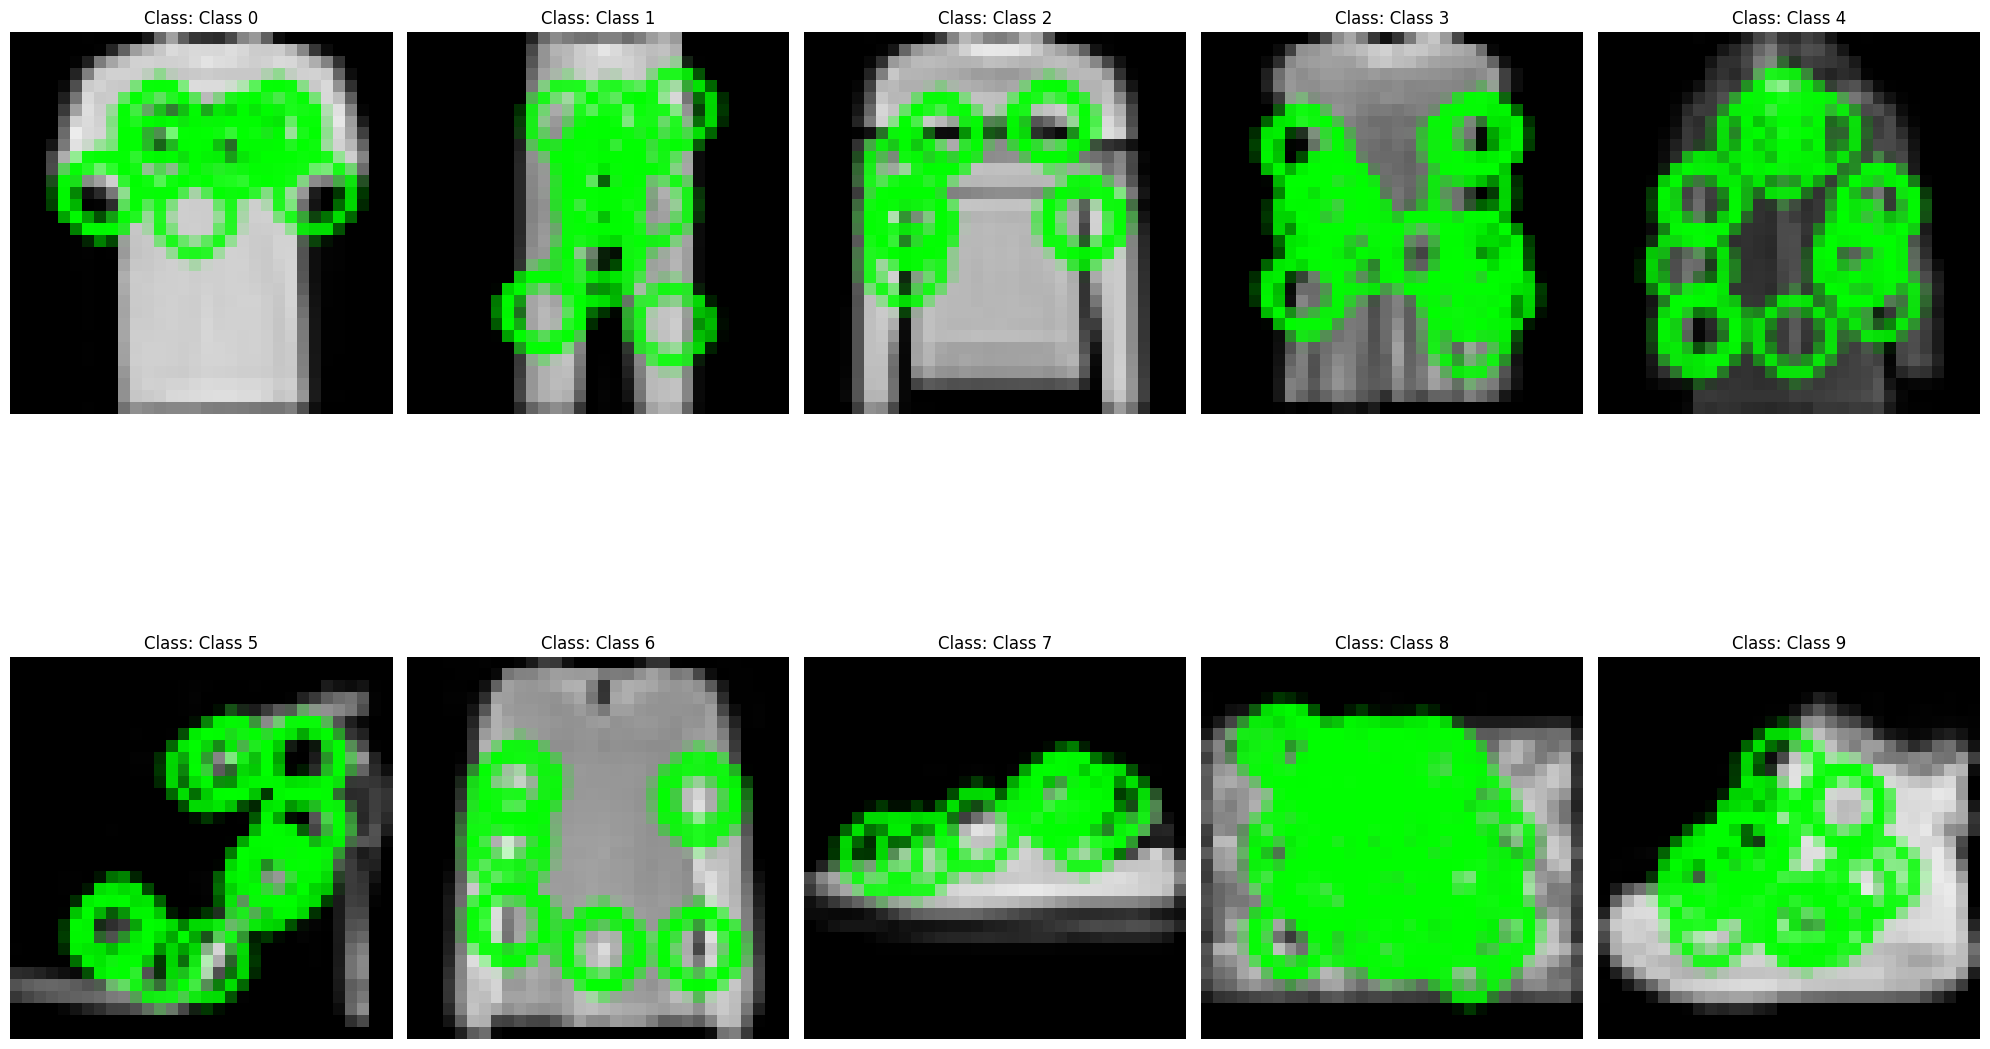

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_orb_keypoints(images, labels, class_names, n=10):
    orb = cv2.ORB_create(nfeatures=300, scaleFactor=1.2, edgeThreshold=6, patchSize=4)
    
    plt.figure(figsize=(20, 15))  
    for i in range(n):
        kp, _ = orb.detectAndCompute(images[i], None)
        image_with_keypoints = cv2.drawKeypoints(images[i], kp, None, color=(0, 255, 0))
        
        row = i // 5  
        col = i % 5   
        
        plt.subplot(2, 5, i+1) 
        plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
        
       
        class_name = class_names[labels[i]]
        plt.title(f"Class: {class_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def select_one_image_from_each_class(train_resized, train_labels, n_classes=10):
    selected_images = []
    selected_labels = []
    
    for class_id in range(n_classes):
  
        class_indices = np.where(train_labels == class_id)[0]
        if len(class_indices) > 0:
            selected_images.append(train_resized[class_indices[0]]) 
            selected_labels.append(class_id) 
    
    return selected_images, selected_labels

class_names = [f"Class {i}" for i in range(10)]  

selected_images, selected_labels = select_one_image_from_each_class(train_resized, train_labels, n_classes=10)


display_orb_keypoints(selected_images, selected_labels, class_names, n=10)


# Etapa 2

## Functions for Data Visualization 


In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # plot loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
# evaluate model on test set
def evaluate_model(model, test_data, test_labels):
    test_loss, test_accuracy = model.evaluate(test_data, test_labels)
    print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
    return test_loss, test_accuracy

# calculate per-class accuracy
def calculate_per_class_accuracy(y_test, y_pred, num_classes):
    accuracy_per_class = []
    for class_idx in range(num_classes):
        class_mask = (y_test == class_idx)
        class_accuracy = np.sum(y_pred[class_mask] == y_test[class_mask]) / np.sum(class_mask)
        accuracy_per_class.append(class_accuracy)
        print(f"Accuracy for class {class_idx}: {class_accuracy:.4f}")
    return accuracy_per_class

# gen classification report and save to CSV
def generate_classification_report_csv(y_test, y_pred, num_classes, filename='classification_report.csv'):
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    accuracy_per_class = calculate_per_class_accuracy(y_test, y_pred, num_classes)

    report_data = {
        'Class': list(range(num_classes)),
        'Precision': [report[str(i)]['precision'] for i in range(num_classes)],
        'Recall': [report[str(i)]['recall'] for i in range(num_classes)],
        'F1 Score': [report[str(i)]['f1-score'] for i in range(num_classes)],
        'Accuracy': accuracy_per_class  # per-class accuracy 
    }
    
    # aave  to CSV
    df_report = pd.DataFrame(report_data)
    df_report.to_csv(filename, index=False)
    print(f"Classification report saved to {filename}")
    return report

# calculate Macro and Weighted avg
def calculate_macro_weighted_averages(report, accuracy_per_class, y_test, num_classes):
    # macro avg
    macro_avg_precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    macro_avg_recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    macro_avg_f1 = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])
    macro_avg_accuracy = np.mean(accuracy_per_class)

    # weighted avg
    support_per_class = [np.sum(y_test == i) for i in range(num_classes)]  # support for each class
    weighted_avg_precision = np.sum([report[str(i)]['precision'] * support_per_class[i] for i in range(num_classes)]) / np.sum(support_per_class)
    weighted_avg_recall = np.sum([report[str(i)]['recall'] * support_per_class[i] for i in range(num_classes)]) / np.sum(support_per_class)
    weighted_avg_f1 = np.sum([report[str(i)]['f1-score'] * support_per_class[i] for i in range(num_classes)]) / np.sum(support_per_class)
    weighted_avg_accuracy = np.sum(np.array(accuracy_per_class) * np.array(support_per_class)) / np.sum(support_per_class)

    # print macro and weighted avg
    print(f"\nMacro Average Precision: {macro_avg_precision:.4f}")
    print(f"Macro Average Recall: {macro_avg_recall:.4f}")
    print(f"Macro Average F1-Score: {macro_avg_f1:.4f}")
    print(f"Macro Average Accuracy: {macro_avg_accuracy:.4f}")

    print(f"\nWeighted Average Precision: {weighted_avg_precision:.4f}")
    print(f"Weighted Average Recall: {weighted_avg_recall:.4f}")
    print(f"Weighted Average F1-Score: {weighted_avg_f1:.4f}")
    print(f"Weighted Average Accuracy: {weighted_avg_accuracy:.4f}")
    
    return macro_avg_precision, macro_avg_recall, macro_avg_f1, macro_avg_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1, weighted_avg_accuracy

# number of classes
num_classes = len(np.unique(train_labels))

## MLP pe atributele extrase în etapa 1

In [20]:
import os
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

physical_devices = tf.config.list_physical_devices('GPU')

# check if GPU is available
if not physical_devices:
    print("No GPU found. Exiting script.")
    exit()  
else:
    print(f"GPU Available: {physical_devices}")
    
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

        


def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))  # input layer
    model.add(Dropout(0.5))  # dropout for reg
    model.add(Dense(64, activation='relu'))  # hidden layer
    model.add(Dense(num_classes, activation='softmax'))  # output layer 
    
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# feature selection using Random Forest
def feature_selection_with_rf(features, labels, max_features=64):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(features, labels)
    
    # select the most important features
    selector = SelectFromModel(rf, max_features=max_features, importance_getter="auto")
    selected_features = selector.transform(features)
    
    return selected_features, selector

# PCA
X_train_scaled, scaler, pca = reduce_dimensionality(train_histograms, n_components=64)
X_test_scaled = pca.transform(scaler.transform(test_histograms))

# feature selection for train and test sets
train_selected, selector = feature_selection_with_rf(X_train_scaled, train_labels, max_features=64)
test_selected = selector.transform(X_test_scaled)


model = create_mlp_model(train_selected.shape[1])

# measure training time
start_time = time.time()

# train the model
fashion_history_feature = model.fit(train_selected, train_labels, epochs=20, batch_size=32, validation_data=(test_selected, test_labels))

end_time = time.time()
training_time = end_time - start_time






GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Explained variance ratio of PCA components: [0.06424672 0.03788581 0.02691151 0.02025288 0.01714004 0.01418763
 0.01292221 0.01238388 0.01186407 0.01144638 0.01091924 0.01071063
 0.01047929 0.01020654 0.0100547  0.00993993 0.00975271 0.00968507
 0.00960188 0.00953535 0.00948943 0.00942392 0.00934894 0.00933473
 0.00929703 0.00922874 0.00918832 0.00916081 0.00913506 0.00908168
 0.00899745 0.00897382 0.00897232 0.00895098 0.00893579 0.00888982
 0.00885074 0.00880686 0.00876414 0.0087271  0.00869787 0.00869564
 0.00868    0.00864509 0.0086053  0.00856154 0.00854633 0.00852041
 0.00849033 0.00846388 0.0084494  0.00841355 0.00838916 0.00838352
 0.00834686 0.00833339 0.00828041 0.00827127 0.00825963 0.00817033
 0.00815963 0.00812967 0.00809608 0.00802696]
Epoch 1/20


/home/regelepirat/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1736693780.835914    8161 service.cc:148] XLA service 0x7c500000ae60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736693780.835939    8161 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-01-12 16:56:20.862578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736693781.045402    8161 cuda_dnn.cc:529] Loaded cuDNN version 90300


  43/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1059 - loss: 2.3453    

I0000 00:00:1736693782.619645    8161 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3874 - loss: 1.7260 - val_accuracy: 0.4817 - val_loss: 1.4484
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4644 - loss: 1.5022 - val_accuracy: 0.4893 - val_loss: 1.4337
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4699 - loss: 1.4839 - val_accuracy: 0.4937 - val_loss: 1.4152
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4745 - loss: 1.4655 - val_accuracy: 0.4922 - val_loss: 1.4102
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4820 - loss: 1.4510 - val_accuracy: 0.4941 - val_loss: 1.4139
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4824 - loss: 1.4503 - val_accuracy: 0.4967 - val_loss: 1.4038
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4867 - loss: 1.4399 - val_accuracy: 0.4970 - val_loss: 1.4028
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4833 - loss: 1.4423 - val_accura

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5039 - loss: 1.3881
Test loss: 1.3986581563949585, Test accuracy: 0.4993000030517578
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for class 0: 0.4330
Accuracy for class 1: 0.7420
Accuracy for class 2: 0.3940
Accuracy for class 3: 0.4700
Accuracy for class 4: 0.3050
Accuracy for class 5: 0.7180
Accuracy for class 6: 0.2300
Accuracy for class 7: 0.5280
Accuracy for class 8: 0.3570
Accuracy for class 9: 0.8160
Accuracy for class 0: 0.4330
Accuracy for class 1: 0.7420
Accuracy for class 2: 0.3940
Accuracy for class 3: 0.4700
Accuracy for class 4: 0.3050
Accuracy for class 5: 0.7180
Accuracy for class 6: 0.2300
Accuracy for class 7: 0.5280
Accuracy for class 8: 0.3570
Accuracy for class 9: 0.8160
Classification report saved to fashion_classification_report_feature.csv

Macro Average Precision: 0.4837
Macro Average Recall: 0.4993
Macro Average F1-Score: 0.4874
Macro Average Accuracy: 0.4993

Weighted Average Precision: 0.4837
Weight

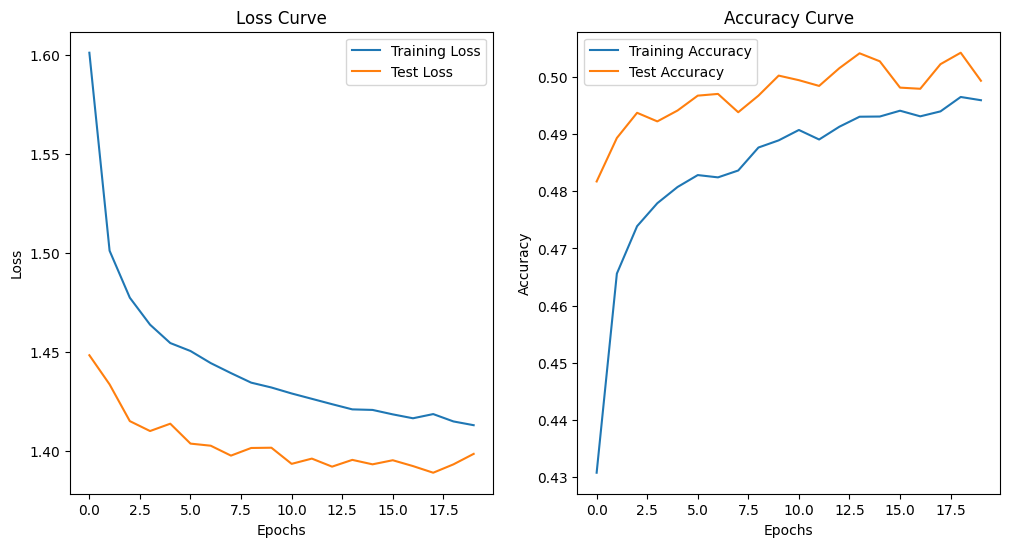


Training time: 119.45 seconds


In [ ]:
# DATA VISUALIZATION

test_loss, test_accuracy = evaluate_model(model, test_selected, test_labels)

y_pred = np.argmax(model.predict(test_selected), axis=1)

accuracy_per_class = calculate_per_class_accuracy(test_labels, y_pred, num_classes)

report = generate_classification_report_csv(test_labels, y_pred, num_classes, filename='fashion_classification_report_feature.csv')

macro_avg_precision, macro_avg_recall, macro_avg_f1, macro_avg_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1, weighted_avg_accuracy = calculate_macro_weighted_averages(report, accuracy_per_class, test_labels, num_classes)


plot_training_history(fashion_history_feature)

print(f"\nTraining time: {training_time:.2f} seconds")


## Arhitectura de tip MLP direct peste imagini

In [ ]:
def flatten_images(images):
    return images.reshape(images.shape[0], -1) 

def normalize_images(images):
    return images / 255.0

train_flattened = flatten_images(train_resized)
test_flattened = flatten_images(test_resized)

train_normalized = normalize_images(train_flattened)
test_normalized = normalize_images(test_flattened)

def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))  # hidden layer 1
    # model.add(Dropout(0.5))  # dropout reg
    model.add(Dense(64, activation='relu'))  # hidden layer 2
    model.add(Dense(num_classes, activation='softmax'))  # output layer 

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_mlp_model(train_normalized.shape[1])

# measure training time
start_time = time.time()

# train the model
history_fashion_original = model.fit(
    train_normalized, train_labels, 
    epochs=20, batch_size=32, 
    validation_data=(test_normalized, test_labels)
)

end_time = time.time()
training_time = end_time - start_time


/home/regelepirat/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-12 16:58:33.674273: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2025-01-12 16:58:33.877526: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6979 - loss: 0.8446 - val_accuracy: 0.8156 - val_loss: 0.4928
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8081 - loss: 0.5211 - val_accuracy: 0.8299 - val_loss: 0.4699
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8269 - loss: 0.4765 - val_accuracy: 0.8535 - val_loss: 0.3967
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8369 - loss: 0.4447 - val_accuracy: 0.8474 - val_loss: 0.4130
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8371 - loss: 0.4432 - val_accuracy: 0.8552 - val_loss: 0.3984
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8439 - loss: 0.4278 - val_accuracy: 0.8557 - val_loss: 0.3966
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8499 - loss: 0.4138 - val_accuracy: 0.8650 - val_loss: 0.3751
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8481 - loss: 0.4116 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8705 - loss: 0.3563
Test loss: 0.3627566993236542, Test accuracy: 0.8708999752998352
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for class 0: 0.8170
Accuracy for class 1: 0.9660
Accuracy for class 2: 0.8130
Accuracy for class 3: 0.8950
Accuracy for class 4: 0.7410
Accuracy for class 5: 0.9720
Accuracy for class 6: 0.6580
Accuracy for class 7: 0.9710
Accuracy for class 8: 0.9780
Accuracy for class 9: 0.8980
Accuracy for class 0: 0.8170
Accuracy for class 1: 0.9660
Accuracy for class 2: 0.8130
Accuracy for class 3: 0.8950
Accuracy for class 4: 0.7410
Accuracy for class 5: 0.9720
Accuracy for class 6: 0.6580
Accuracy for class 7: 0.9710
Accuracy for class 8: 0.9780
Accuracy for class 9: 0.8980
Classification report saved to fashion_classification_report_original.csv

Macro Average Precision: 0.8714
Macro Average Recall: 0.8709
Macro Average F1-Score: 0.8705
Macro Average Accuracy: 0.8709

Weighted Average Precision: 0.8714
Weigh

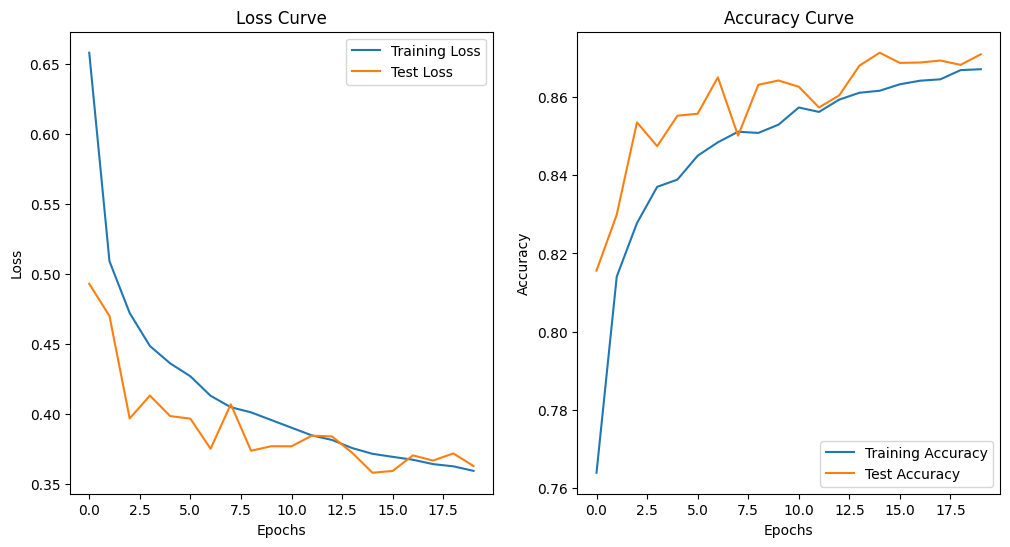


Training time: 131.73 seconds


In [ ]:
# DATA VISUALIZATION

test_loss, test_accuracy = evaluate_model(model, test_normalized, test_labels)


y_pred = np.argmax(model.predict(test_normalized), axis=1)

accuracy_per_class = calculate_per_class_accuracy(test_labels, y_pred, num_classes)


report = generate_classification_report_csv(test_labels, y_pred, num_classes, filename='fashion_classification_report_original.csv')

macro_avg_precision, macro_avg_recall, macro_avg_f1, macro_avg_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1, weighted_avg_accuracy = calculate_macro_weighted_averages(report, accuracy_per_class, test_labels, num_classes)


plot_training_history(history_fashion_original)

print(f"\nTraining time: {training_time:.2f} seconds")



## Arhitectura de tip convoluțional

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import numpy as np

def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # conv1: 32 filters, 3x3 kernel, ReLU activation
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # conv2: 64 filters, 3x3 kernel, ReLU activation
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # conv3: 128 filters, 3x3 kernel, ReLU activation
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # global average pooling
    model.add(GlobalAveragePooling2D())

    # fully connected layers 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.7))  # dropout
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# apply data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,  # random rotation
    width_shift_range=0.2,  # random horizontal shift
    height_shift_range=0.2,  # random vertical shift
    shear_range=0.2,  # shear transformation
    zoom_range=0.2,  # random zoom
    horizontal_flip=True,  # random horizontal flip
    fill_mode='nearest'  # fill empty pixels 
)

train_resized_normalized = normalize_images(train_resized)
test_resized_normalized = normalize_images(test_resized)

# add a channel dimension
train_resized_normalized = train_resized_normalized[..., np.newaxis]  
test_resized_normalized = test_resized_normalized[..., np.newaxis] 

input_shape = train_resized_normalized.shape[1:]


model_no_augmentation = create_cnn_model(input_shape, num_classes)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# measure training time for no augmentation
start_time_no_aug = time.time()

history_fashion_no_augmentation = model_no_augmentation.fit(
    train_resized_normalized, train_labels, 
    epochs=20, batch_size=32, 
    validation_data=(test_resized_normalized, test_labels),
    callbacks=[early_stopping, reduce_lr]  #  early stopping and LR scheduler
)

end_time_no_aug = time.time()
training_time_no_aug = end_time_no_aug - start_time_no_aug

# train the model 
model_with_augmentation = create_cnn_model(input_shape, num_classes)

# measure training time 
start_time_aug = time.time()

history_fashion_with_augmentation = model_with_augmentation.fit(
    datagen.flow(train_resized_normalized, train_labels, batch_size=32), 
    epochs=20, 
    validation_data=(test_resized_normalized, test_labels),
    callbacks=[early_stopping, reduce_lr]  # early stopping and LR scheduler
)

end_time_aug = time.time()
training_time_aug = end_time_aug - start_time_aug


/home/regelepirat/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7052 - loss: 0.8569 - val_accuracy: 0.8374 - val_loss: 0.4344 - learning_rate: 0.0010
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8518 - loss: 0.4234 - val_accuracy: 0.8714 - val_loss: 0.3425 - learning_rate: 0.0010
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8689 - loss: 0.3712 - val_accuracy: 0.8689 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8844 - loss: 0.3321 - val_accuracy: 0.8944 - val_loss: 0.2900 - learning_rate: 0.0010
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8903 - loss: 0.3101 - val_accuracy: 0.8923 - val_loss: 0.3015 - learning_rate: 0.0010
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8994 - loss: 0.2850 - val_accuracy: 0.8986 - val_loss: 0.2791 - learning_rate: 0.0010
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9

/home/regelepirat/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.5116 - loss: 1.3815 - val_accuracy: 0.7234 - val_loss: 0.7205 - learning_rate: 0.0010
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.6974 - loss: 0.8316 - val_accuracy: 0.7503 - val_loss: 0.7388 - learning_rate: 0.0010
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.7276 - loss: 0.7569 - val_accuracy: 0.7752 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.7491 - loss: 0.7039 - val_accuracy: 0.7610 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.7598 - loss: 0.6771 - val_accuracy: 0.7910 - val_loss: 0.5566 - learning_rate: 0.0010
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.7701 - loss: 0.6479 - val_accuracy: 0.7748 - val_loss: 0.6382 - learning_rate: 0.0010
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.7794 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9099 - loss: 0.2719
Test loss: 0.2644263207912445, Test accuracy: 0.9110000133514404
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8521 - loss: 0.4078
Test loss: 0.4119935631752014, Test accuracy: 0.8504999876022339
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

No augmentation
Accuracy for class 0: 0.9000
Accuracy for class 1: 0.9840
Accuracy for class 2: 0.8950
Accuracy for class 3: 0.9270
Accuracy for class 4: 0.8910
Accuracy for class 5: 0.9750
Accuracy for class 6: 0.6170
Accuracy for class 7: 0.9800
Accuracy for class 8: 0.9860
Accuracy for class 9: 0.9550

Augmentation
Accuracy for class 0: 0.8870
Accuracy for class 1: 0.9740
Accuracy for class 2: 0.8860
Accuracy for class 3: 0.8000
Accuracy for class 4: 0.7440
Accuracy for class 5: 0.9300
Accuracy for class 6: 0.4390
Accuracy for class 7: 0.9030
Accuracy for class 8: 0.9820
Accuracy for class 9: 0.9600

No augmentation
Accuracy f

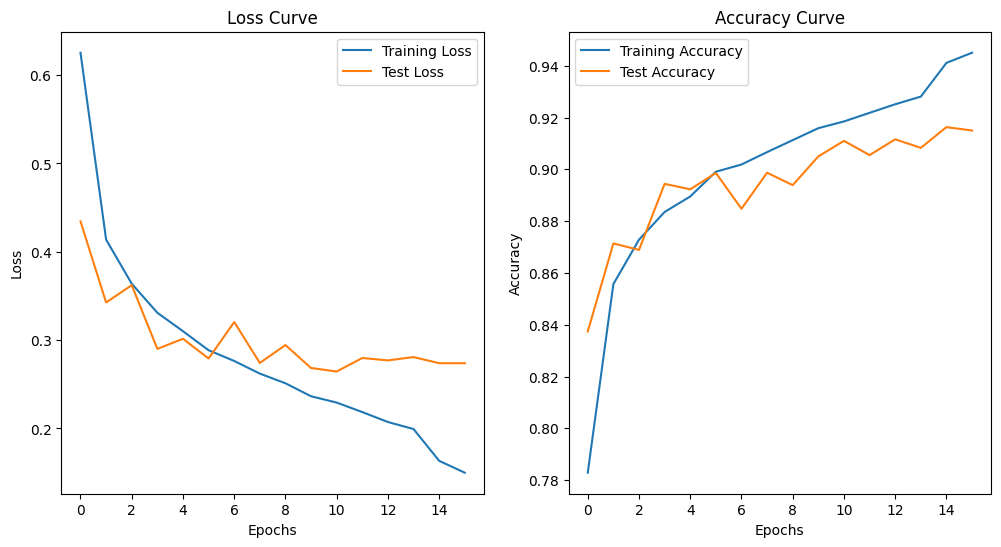


Augmentation


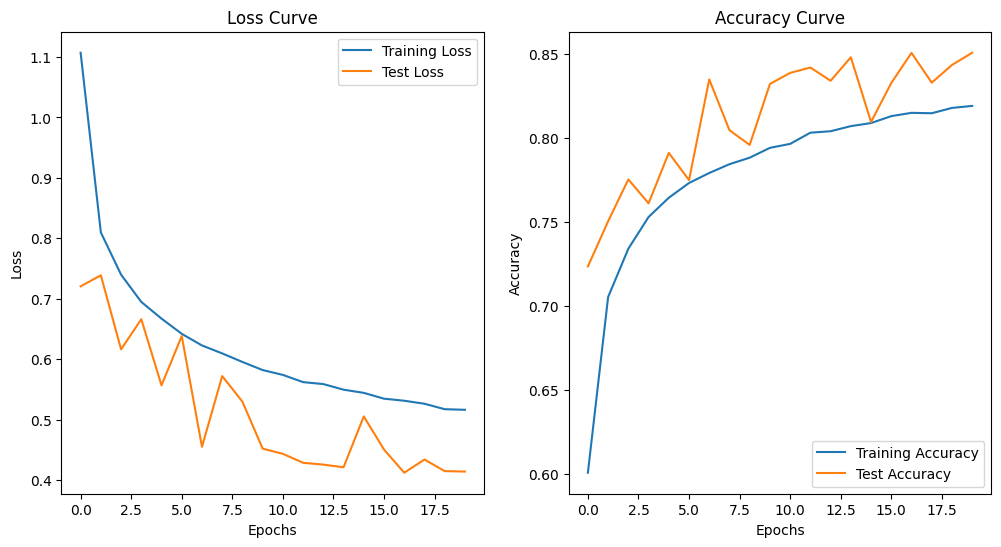


Training time no augmentation: 193.69 seconds

Training time augmentation: 599.07 seconds


In [ ]:
# DATA VISUALIZATION
test_loss_no_augmentation, test_accuracy_no_augmentation = evaluate_model(model_no_augmentation, test_resized_normalized, test_labels)
test_loss_with_augmentation, test_accuracy_with_augmentation = evaluate_model(model_with_augmentation, test_resized_normalized, test_labels)

y_pred_no_augmentation = np.argmax(model_no_augmentation.predict(test_resized_normalized), axis=1)
y_pred_with_augmentation = np.argmax(model_with_augmentation.predict(test_resized_normalized), axis=1)

print(f"\nNo augmentation")
accuracy_per_class_no_augmentation = calculate_per_class_accuracy(test_labels, y_pred_no_augmentation, num_classes)

print(f"\nAugmentation")
accuracy_per_class_with_augmentation = calculate_per_class_accuracy(test_labels, y_pred_with_augmentation, num_classes)

print(f"\nNo augmentation")
report_no_augmentation = generate_classification_report_csv(test_labels, y_pred_no_augmentation, num_classes, filename='fashion_classification_report_no_augmentation.csv')

print(f"\nAugmentation")
report_with_augmentation = generate_classification_report_csv(test_labels, y_pred_with_augmentation, num_classes, filename='fashion_classification_report_augmentation.csv')

print(f"\nNo augmentation")
macro_avg_no_augmentation, macro_avg_recall_no_augmentation, macro_avg_f1_no_augmentation, macro_avg_accuracy_no_augmentation, weighted_avg_precision_no_augmentation, weighted_avg_recall_no_augmentation, weighted_avg_f1_no_augmentation, weighted_avg_accuracy_no_augmentation = calculate_macro_weighted_averages(report_no_augmentation, accuracy_per_class_no_augmentation, test_labels, num_classes)

print(f"\nAugmentation")
macro_avg_with_augmentation, macro_avg_recall_with_augmentation, macro_avg_f1_with_augmentation, macro_avg_accuracy_with_augmentation, weighted_avg_precision_with_augmentation, weighted_avg_recall_with_augmentation, weighted_avg_f1_with_augmentation, weighted_avg_accuracy_with_augmentation = calculate_macro_weighted_averages(report_with_augmentation, accuracy_per_class_with_augmentation, test_labels, num_classes)

print(f"\nNo augmentation")
plot_training_history(history_fashion_no_augmentation)

print(f"\nAugmentation")
plot_training_history(history_fashion_with_augmentation)

print(f"\nTraining time no augmentation: {training_time_no_aug:.2f} seconds")
print(f"\nTraining time augmentation: {training_time_aug:.2f} seconds")


## Utilizarea unei proceduri de finetuning peste arhitectura ResNet-18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import time
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )




class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)  # 3 channels
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(pretrained=False, num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# data pre-processing and augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert to 3 channels
    transforms.Resize((32, 32)),  # resize 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert to 3 channels
    transforms.Resize((32, 32)),  # resize 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#  dataset for FashionMNIST
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])  
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = FashionMNISTDataset(train_images, train_labels, transform=transform_train)
test_dataset = FashionMNISTDataset(test_images, test_labels, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# init the model
model = resnet18(pretrained=False, num_classes=num_classes)  
model.to(device)

# freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)  # fine-tune the final layer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# loss function
criterion = nn.CrossEntropyLoss()

# training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_preds.double() / total_preds
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # validation loop
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels)
                total_preds += labels.size(0)

        val_epoch_loss = val_loss / len(test_loader)
        val_epoch_acc = correct_preds.double() / total_preds
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# measure training time
start_time = time.time()

num_epochs = 20
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, scheduler, num_epochs)

end_time = time.time()
training_time = end_time - start_time



Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7c51128a6710>
Traceback (most recent call last):
  File "/home/regelepirat/.pyenv/versions/3.10.14/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 
/home/regelepirat/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


TypeError: to() received an invalid combination of arguments - got (PhysicalDevice), but expected one of:
 * (torch.device device = None, torch.dtype dtype = None, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (torch.dtype dtype, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (Tensor tensor, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)


Test loss: 0.8015658997308713, Test accuracy: 0.7192
Accuracy for class 0: 0.6600
Accuracy for class 1: 0.9130
Accuracy for class 2: 0.5720
Accuracy for class 3: 0.7140
Accuracy for class 4: 0.6690
Accuracy for class 5: 0.7500
Accuracy for class 6: 0.3620
Accuracy for class 7: 0.8770
Accuracy for class 8: 0.8250
Accuracy for class 9: 0.8500
Accuracy for class 0: 0.6600
Accuracy for class 1: 0.9130
Accuracy for class 2: 0.5720
Accuracy for class 3: 0.7140
Accuracy for class 4: 0.6690
Accuracy for class 5: 0.7500
Accuracy for class 6: 0.3620
Accuracy for class 7: 0.8770
Accuracy for class 8: 0.8250
Accuracy for class 9: 0.8500
Classification report saved to fashion_classification_report_resnet.csv

Macro Average Precision: 0.7181
Macro Average Recall: 0.7192
Macro Average F1-Score: 0.7157
Macro Average Accuracy: 0.7192

Weighted Average Precision: 0.7181
Weighted Average Recall: 0.7192
Weighted Average F1-Score: 0.7157
Weighted Average Accuracy: 0.7192


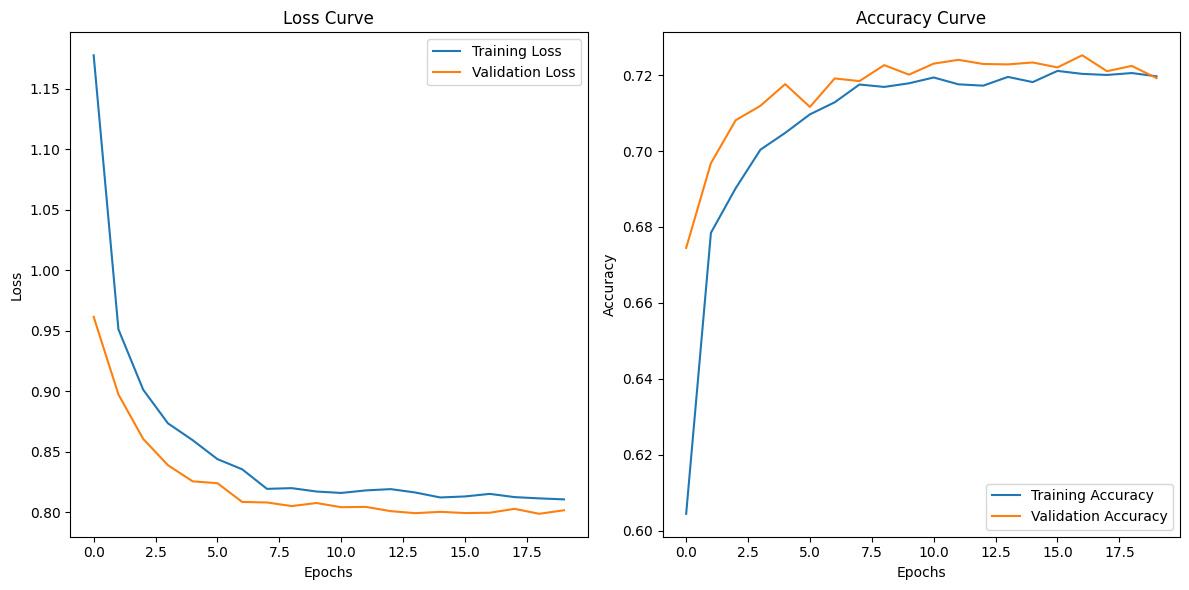


Training time: 1228.05 seconds


In [40]:
# DATA VISUALIZATION

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss, test_accuracy = 0.0, 0.0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)
    
    test_loss /= len(test_loader)
    test_accuracy = correct_preds.double() / total_preds
    print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy


def make_predictions(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred)


def plot_training_history(train_loss, train_acc, val_loss, val_acc):
    plt.figure(figsize=(12, 6))

    # loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

y_true, y_pred = make_predictions(model, test_loader)

accuracy_per_class = calculate_per_class_accuracy(y_true, y_pred, num_classes)

report = generate_classification_report_csv(y_true, y_pred, num_classes, filename='fashion_classification_report_resnet.csv')

macro_avg_precision, macro_avg_recall, macro_avg_f1, macro_avg_accuracy, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1, weighted_avg_accuracy = calculate_macro_weighted_averages(report, accuracy_per_class, y_true, num_classes=10)

plot_training_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

print(f"\nTraining time: {training_time:.2f} seconds")

